# Machine Learning Trading Bot

In [291]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance


### Step 1: mport the OHLCV dataset into a Pandas DataFrame.

In [351]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [352]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [353]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [354]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [355]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [356]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

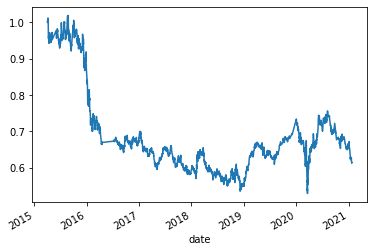

In [357]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [358]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [359]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [360]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [361]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [362]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [363]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [364]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [375]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [389]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [378]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df["Strategy Returns"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,0.025715
2015-07-06 10:45:00,1.0,0.007237,-0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,0.003841
2015-07-07 11:30:00,1.0,-0.018423,0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,-0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

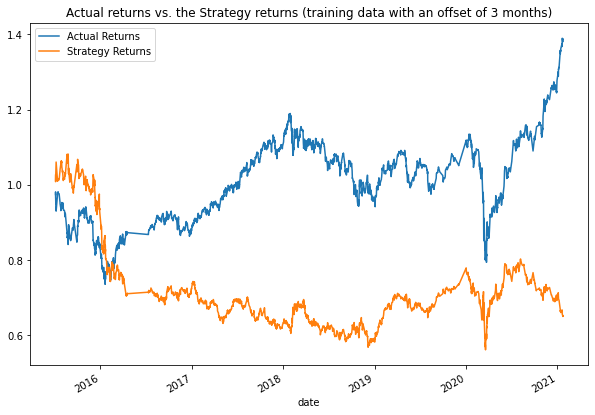

In [379]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns (training data with an offset of 3 months)")

In [380]:
# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/Actual_vs_Strategy_3_month.png")

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

              precision    recall  f1-score   support

        -1.0       0.44      0.02      0.04      1732
         1.0       0.56      0.98      0.71      2211

    accuracy                           0.56      3943
   macro avg       0.50      0.50      0.38      3943
weighted avg       0.51      0.56      0.42      3943



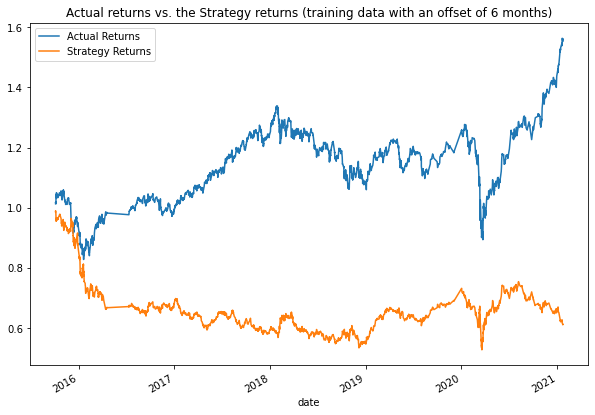

In [113]:
# Select the ending period for the training data with an offset of 6 months

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns (training data with an offset of 6 months)")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/Actual_vs_Strategy_6_month.png")

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      1497
         1.0       0.56      1.00      0.72      1931

    accuracy                           0.56      3428
   macro avg       0.28      0.50      0.36      3428
weighted avg       0.32      0.56      0.41      3428



C:\Users\vglup\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vglup\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vglup\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


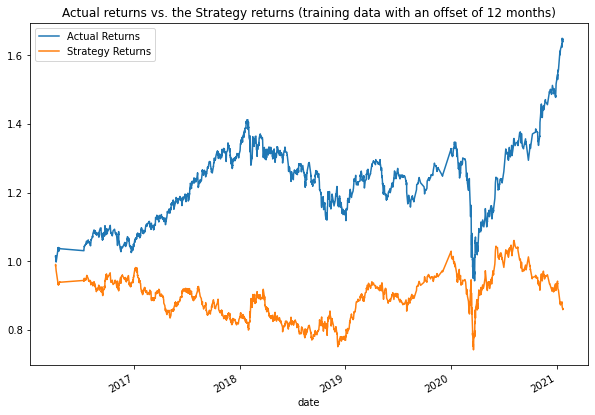

In [121]:
# Select the ending period for the training data with an offset of 12 months

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns (training data with an offset of 12 months)")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/Actual_vs_Strategy_12_month.png")

              precision    recall  f1-score   support

        -1.0       0.75      0.00      0.00      1430
         1.0       0.56      1.00      0.72      1843

    accuracy                           0.56      3273
   macro avg       0.66      0.50      0.36      3273
weighted avg       0.64      0.56      0.41      3273



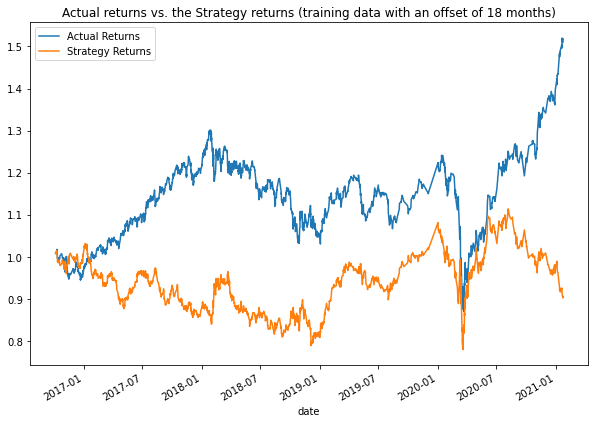

In [129]:
# Select the ending period for the training data with an offset of 18 months

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns (training data with an offset of 18 months)")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/Actual_vs_Strategy_18_month.png")

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      1694
         1.0       0.56      1.00      0.72      2161

    accuracy                           0.56      3855
   macro avg       0.28      0.50      0.36      3855
weighted avg       0.31      0.56      0.40      3855



C:\Users\vglup\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vglup\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vglup\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


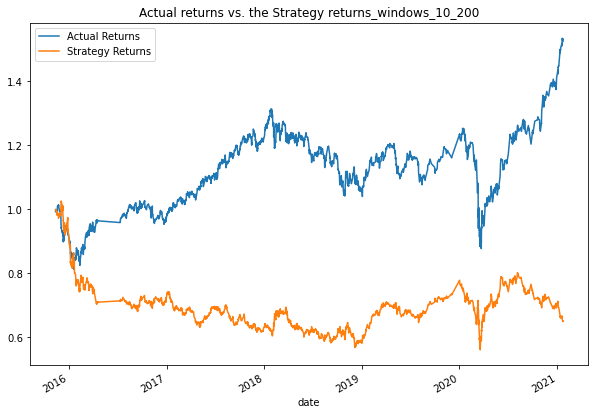

In [162]:
# Set the short window and long window 10 and 200

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns_windows_10_200")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/windows_10_200.png")

              precision    recall  f1-score   support

        -1.0       0.44      0.88      0.59      1598
         1.0       0.59      0.13      0.21      2075

    accuracy                           0.46      3673
   macro avg       0.51      0.51      0.40      3673
weighted avg       0.52      0.46      0.38      3673



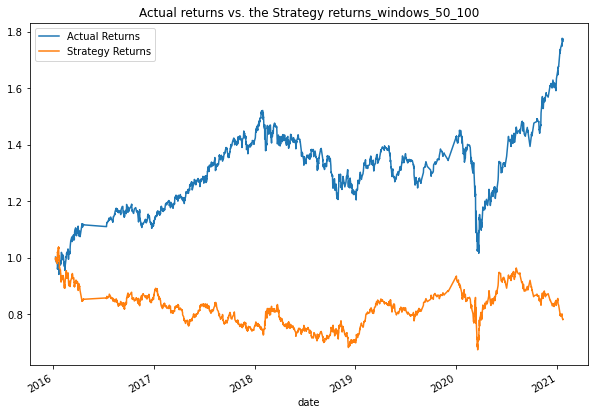

In [178]:
# Set the short window and long window 50 and 100

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns_windows_50_100")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/windows_50_100.png")

              precision    recall  f1-score   support

        -1.0       0.43      1.00      0.61      1554
         1.0       0.80      0.01      0.01      2027

    accuracy                           0.44      3581
   macro avg       0.62      0.50      0.31      3581
weighted avg       0.64      0.44      0.27      3581



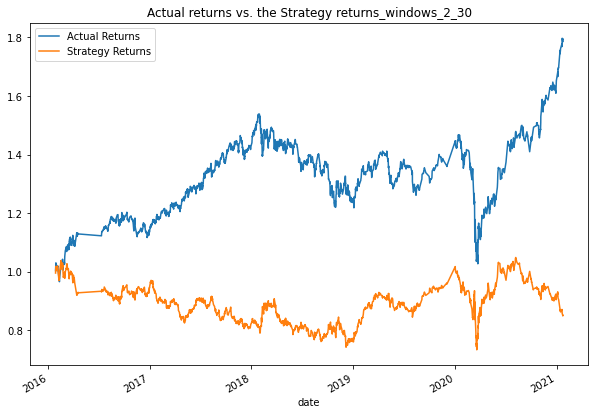

In [194]:
# Set the short window and long window 2 and 30

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns_windows_2_30")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/windows_2_30.png")

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

              precision    recall  f1-score   support

        -1.0       0.43      0.19      0.27      1651
         1.0       0.56      0.81      0.66      2120

    accuracy                           0.54      3771
   macro avg       0.50      0.50      0.46      3771
weighted avg       0.51      0.54      0.49      3771



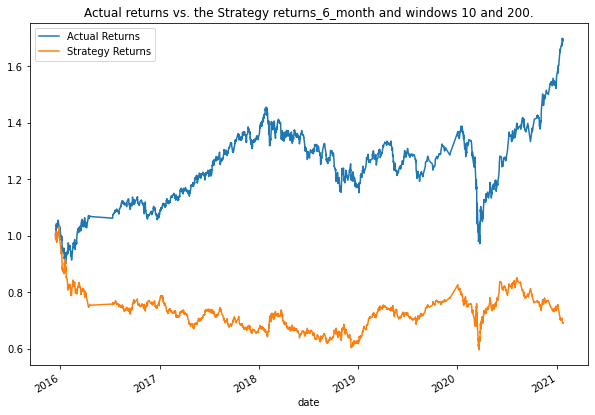

In [233]:
# Select the ending period for the training data with an offset of 6 months and the short window and long window 10 and 200

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns_6_month and windows 10 and 200.")

# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/Actual_vs_Strategy_6_month_windows_10_200.png")

---

## Evaluate a New Machine Learning Classifier 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [381]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [387]:
# Fit the model using the training data
model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = logistic_regression_model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 3: Backtest the new model to evaluate its performance. 

In [383]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_training_report = classification_report(y_test, pred)

# Print the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1804
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4092
   macro avg       0.50      0.50      0.49      4092
weighted avg       0.51      0.52      0.51      4092



In [390]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_lr = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df_lr['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_df_lr['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df_lr['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df_lr['Predicted'].shift()

# Review the DataFrame
display(predictions_df_lr.head())
display(predictions_df_lr.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,NaN
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


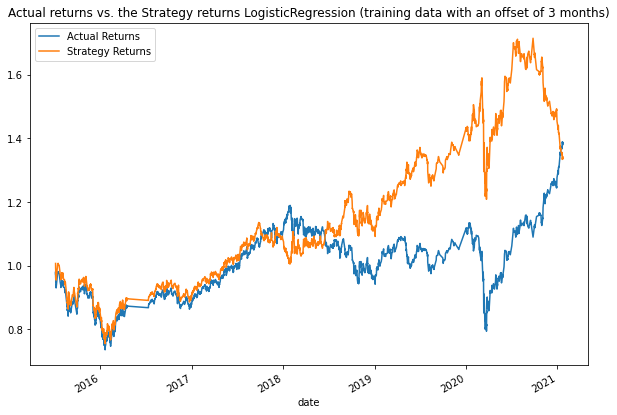

In [392]:
# Plot the actual returns versus the strategy returns
plot = (1 + predictions_df_lr[["Actual Returns", "Strategy Returns"]]).cumprod().plot(figsize=(10,7), title="Actual returns vs. the Strategy returns LogisticRegression (training data with an offset of 3 months)")

In [397]:
# Save plot to the file
fig = plot.get_figure()
fig.savefig("Images/Actual_vs_Strategy_3_month_LogisticRegression.png")